In [3]:
import logging
import os
import sys
import math
sys.path.append('scripts')
sys.path.append('share')
sys.path.append('python')
from collections import namedtuple
import numpy as np
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import tensorflow
import tensorflow.keras as keras
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from run_training import _build_model, _find_py_file

In [6]:
with h5.File('output/apply_outdata.h5', 'r') as data:
    outdata = data['outdata'][()]
Outputnumber = outdata['Output_number']
Outputnumber = outdata['Output_number_true']


In [58]:
#logging.basicConfig(level=1, format='[%(asctime)s %(levelname)s] %(message)s')
#logging.getLogger('matplotlib').setLevel = logging.ERROR
Option = namedtuple("MyStruct", "input model name folds")
                    #structure learning_rate regularizer epochs")
args = Option(
    input='data/test1.h5',
    model='share/reference_number.py',
    name='NumberNetworkKFOLD',
    folds=10,
    #batch_size=60,
    #epochs=20,
    #learning_rate=0.0001,
    #regularizer=0.0001,
)

path = _find_py_file(args.model)

## Loading Data

In [9]:
logging.info(f'Loading data from {args.input}')

with h5.File(args.input, 'r') as data:
    data_x = data['input'][()]
    data_y = data['target'][()]

labels = ['1particle', '2particle', '3particle']

In [9]:
with h5.File("data/testtotal.h5") as data:
    data_EC = data['NN_barrelEC'][()]
    data_Layer = data['NN_layer'][()]
    data_1 = data['Output_number1'][()]
    data_2 = data['Output_number2'][()]
    data_3 = data['Output_number3'][()]
    data_true = data['Output_number_true'][()]

s = np.arange(data_EC.shape[0])
np.random.shuffle(s)

data_EC = data_EC[s]
data_Layer = data_Layer[s]
data_1 = data_1[s]
data_2 = data_2[s]
data_3 = data_3[s]
data_true = data_true[s]

In [13]:
with h5.File("output/apply_outdata.h5") as data:
    data_EC = data['NN_barrelEC'][()]
    data_Layer = data['NN_layer'][()]
    data_number = data['Output_number'][()]
    data_true = data['Output_number_true'][()]

s = np.arange(data_EC.shape[0])
np.random.shuffle(s)

data_EC = data_EC[s]
data_Layer = data_Layer[s]
data_number = data_number[s]
data_true = data_true[s]

## Calculate Inference

In [10]:
model, compile_args, fit_args, params = _build_model(path, data_x, data_y)
compile_args['metrics']=['accuracy']
model.compile(**compile_args)
model.load_weights('modelWeights/NumberNetworkKFOLD1.h5')
#model.load_weights('modelWeights/LGNumberNetworkModel.h5')

y_pred = model.predict(data_x)

AttributeError: 'Model' object has no attribute 'load_model'

## Plot ROCs by Layer and Label

In [70]:
def doNumber(data_x, data_y, pred_y):
    data = {}
    outdata = np.zeros(
        (pred_y.shape[0],),
        dtype=[
            ('Output_number', np.dtype(('f4', 3))),
            ('Output_number_true', 'i4')
        ]
    )

    outdata['Output_number'] = pred_y / np.sum(pred_y, axis=1, keepdims=True)
    outdata['Output_number_true'] = 1 * data_y[:, 0] + \
                                    2 * data_y[:, 1] + \
                                    3 * data_y[:, 2]

    IBL = np.logical_and(data_x[:, 56] == 0, data_x[:, 57] == 0)
    Barrel = np.logical_and(data_x[:, 56] > 0, data_x[:, 57] == 0)
    Endcap = data_x[:, 57] != 0

    data['IBL'] = outdata[IBL]
    data['Barrel'] = outdata[Barrel]
    data['Endcap'] = outdata[Endcap]
    return data

def rocGraph(data, classes):
    pos, neg = classes
    linetypes = ['-', '--', ':']

    for i, layer in enumerate(data):

        pos_sel = data[layer]['Output_number_true'] == pos
        neg_sel = data[layer]['Output_number_true'] == neg

        isel = np.where(
            np.logical_or(
                pos_sel,
                neg_sel,
            )
        )[0]

        fpr, tpr, _ = roc_curve(
            data[layer]['Output_number_true'][isel],
            data[layer]['Output_number'][isel][:, pos - 1],
            pos_label=pos
        )
        auc1 = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, linetypes[i], label=f'{layer} (AUC = {auc1:.2f})')
        
        
    rand_chance = np.linspace(0, 1, 100)
    plt.plot(rand_chance,rand_chance, ':', color='grey', label='Random (AUC = 0.5)')
    plt.semilogx()
    plt.ylabel(f"Pr(Estimated: {pos}-particle | True: {pos}-particle)")
    plt.xlabel(f"Pr(Estimated: {pos}-particle | True: {neg}-particle)")
    plt.xlim([0.001, 1.05])
    plt.ylim(0,1.05)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.figtext(0.25, 0.90,f'{pos} vs {neg}',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=10)
    plt.savefig(f'output/{pos}{neg}_ROC.png')
    plt.close()
    

def doRocs(data):
    rocGraph(data, (3, 2))
    rocGraph(data, (3, 1))
    rocGraph(data, (2, 3))
    rocGraph(data, (2, 1))
    rocGraph(data, (1, 2))
    rocGraph(data, (1, 3))

In [40]:
data = doNumber(data_x, data_y, y_pred)
doRocs(data)

NameError: name 'data_x' is not defined

In [17]:
def doNumber2(data_EC, data_Layer, data_1, data_2, data_3, data_true):

    data = {}

    outdata = np.zeros(
        (data_1.shape[0],),
        dtype=[
            ('Output_number', np.dtype(('f4', 3))),
            ('Output_number_true', 'i4')
        ]
    )

    IBL = np.logical_and(data_Layer == 0, data_EC == 0)
    Barrel = np.logical_and(data_Layer > 0, data_EC == 0)
    Endcap = data_EC != 0

    outdata['Output_number'] = np.array([data_1, data_2, data_3]).T
    outdata['Output_number_true'] = data_true

    data['IBL'] = outdata[IBL]
    data['Barrel'] = outdata[Barrel]
    data['Endcap'] = outdata[Endcap]
    return data

def rocGraph2(data, classes):

    fpr = [[0]*(10) for i in range(len(data))]
    tpr = [[0]*(10) for i in range(len(data))]
    auc1 = [[0]*(10) for i in range(len(data))]

    npoints = 200
    base_fpr = np.exp(np.linspace(math.log(0.0005), 0., npoints))
    colors = ["r", "g", "b"]

    pos, neg = classes
    linetypes = ['-', '--', ':']

    for j, layer in enumerate(data):

        for i, data_split in enumerate(data[layer]):
        
            pos_sel = data_split['Output_number_true'] == pos
            neg_sel = data_split['Output_number_true'] == neg

            isel = np.where(
                np.logical_or(
                    pos_sel,
                    neg_sel,
                )
            )[0]

            fpr[j][i], tpr[j][i], _ = roc_curve(
                data_split['Output_number_true'][isel],
                data_split['Output_number'][isel][:, pos - 1],
                pos_label=pos
            )
            auc1[j][i] = auc(fpr[j][i], tpr[j][i])
        
    for i, layer in enumerate(data):
        
        tpr_array = np.array([])

        for j in range(10):
            tpr_interpolated = np.interp(base_fpr, fpr[i][j], tpr[i][j])
            tpr_interpolated = tpr_interpolated.reshape((1,npoints))
            tpr_array = np.concatenate([tpr_array, tpr_interpolated], axis=0) if tpr_array.size else tpr_interpolated
            
        mean_tpr = np.mean(tpr_array, axis=0)
        rms_tpr = np.std(tpr_array, axis=0)
        plus_tpr = np.minimum(mean_tpr+rms_tpr, np.ones(npoints))
        minus_tpr = np.maximum(mean_tpr-rms_tpr,np.zeros(npoints))
        plt.plot(base_fpr, mean_tpr, linetypes[i], label=f'{layer} (AUC = {np.mean(auc1[i][j][()]):.2f} (+- {np.std(auc1[i][j][()]):.4f}))')
        print(np.std(auc_list[i][()]))
        plt.fill_between(base_fpr, minus_tpr, plus_tpr, alpha=0.3)
        
        
    rand_chance = np.linspace(0, 1, 100)
    plt.plot(rand_chance,rand_chance, ':', color='grey', label='Random (AUC = 0.5)')
    plt.semilogx()
    plt.ylabel(f"Pr(Estimated: {pos}-particle | True: {pos}-particle)")
    plt.xlabel(f"Pr(Estimated: {pos}-particle | True: {neg}-particle)")
    plt.xlim([0.001, 1.05])
    plt.ylim(0,1.05)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.figtext(0.25, 0.90,f'{pos} vs {neg}',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=10)
    plt.savefig(f'output/{pos}{neg}_ROC.png')
    plt.close()
    

def doRocs2(data):
    rocGraph2(data, (3, 2))
    rocGraph2(data, (3, 1))
    rocGraph2(data, (2, 3))
    rocGraph2(data, (2, 1))
    rocGraph2(data, (1, 2))
    rocGraph2(data, (1, 3))

In [15]:
def doNumber3(data_EC, data_Layer, data_number, data_true):

    data = {}

    outdata = np.zeros(
        (data_number.shape[0],),
        dtype=[
            ('Output_number', np.dtype(('f4', 3))),
            ('Output_number_true', 'i4')
        ]
    )

    IBL = np.logical_and(data_Layer == 0, data_EC == 0)
    Barrel = np.logical_and(data_Layer > 0, data_EC == 0)
    Endcap = data_EC != 0

    outdata['Output_number'] = data_number
    outdata['Output_number_true'] = data_true

    data['IBL'] = outdata[IBL]
    data['Barrel'] = outdata[Barrel]
    data['Endcap'] = outdata[Endcap]
    return data

In [18]:
data = doNumber3(data_EC, data_Layer, data_number, data_true)
for i, layer in enumerate(data):
    data[layer] = np.array_split(data[layer], 10)
doRocs2(data)

In [ ]:
## Calculate K-Fold ROCs

For 10 Kfold models and LG's model on Test.h5

In [4]:
folds = args.folds
fpr_LG = [0]*len(labels)
tpr_LG = [0]*len(labels)
auc_LG = [0]*len(labels)

fpr_list = [[0]*(folds) for i in range(len(labels))]
tpr_list = [[0]*(folds) for i in range(len(labels))]
auc_list = [[0]*(folds) for i in range(len(labels))]

logging.info('Building model from %s', path)
model, compile_args, fit_args, params = _build_model(path, data_x, data_y)
compile_args['metrics']=['accuracy']
model.compile(**compile_args)
model.load_weights('modelWeights/LGNumberNetworkModel.h5')

logging.info('Predicting...')
#scores = model.evaluate(data_x[:5000], data_y[:5000])
y_pred = model.predict(data_x)


for i, label in enumerate(labels):
    fpr_LG[i], tpr_LG[i], threshold = roc_curve(data_y[:][:,i], y_pred[:,i])
    auc_LG[i] = auc(fpr_LG[i], tpr_LG[i])

logging.info('Done')

[2020-07-12 14:35:23,778 INFO] Building model from share/reference_number.py
[2020-07-12 14:35:29,070 INFO] Predicting...
[2020-07-12 14:38:24,672 INFO] Done


LG complete


For LG's model on Total.h5 split into 10 testing sets

In [6]:
folds = 10
fold_no = 0

fpr_list = [[0]*(folds) for i in range(len(labels))]
tpr_list = [[0]*(folds) for i in range(len(labels))]
auc_list = [[0]*(folds) for i in range(len(labels))]

kfold = KFold(n_splits=args.folds)
splits = kfold.split(data_x,data_y)

model, compile_args, fit_args, params = _build_model(path, data_x, data_y)
compile_args['metrics']=['accuracy']
model.compile(**compile_args)
model.load_weights(f'modelWeights/LGNumberNetworkModel.h5')

for train, test in splits:
    
    
    y_pred = model.predict(data_x[test])

    if np.isnan(y_pred).any():
        print('Nan Val')
    for j, label in enumerate(labels):
        fpr_list[j][fold_no], tpr_list[j][fold_no], threshold = roc_curve(data_y[test][:,j], y_pred[:,j])
        auc_list[j][fold_no] = auc(fpr_list[j][fold_no], tpr_list[j][fold_no])

    fold_no += 1
    print(f'{fold_no} fold complete')

print(f'LG complete')

1 fold complete
2 fold complete
3 fold complete
4 fold complete
5 fold complete
6 fold complete
7 fold complete
8 fold complete
9 fold complete
10 fold complete
LG complete


## Plot ROCS

In [23]:
def kfoldRoc(infile, labels, name="", outdir="", fprl=None, tprl=None, aucl=None):

    folds = 10
    npoints = 200
    base_fpr = np.exp(np.linspace(math.log(0.0005), 0., npoints))
    colors = ["r", "g", "b"]
    avg_tpr = {}
    plus_tpr = {}
    minus_tpr = {}

    if (fprl==None):
        fprl = [[0]*(folds) for i in range(len(labels))]
        tprl = [[0]*(folds) for i in range(len(labels))]
        aucl = [[0]*(folds) for i in range(len(labels))]
        with h5.File(infile, 'r') as hfile:
            for i, label in enumerate(labels):
                for j in range(folds):
                    fprl[i][j] = hfile[f'{label}_{j+1}_fpr'][()]
                    tprl[i][j] = hfile[f'{label}_{j+1}_tpr'][()]
                    aucl[i][j] = hfile[f'{label}_{j+1}_auc'][()]
                    
    fpr_list = np.array(fprl)
    tpr_list = np.array(tprl)
    auc_list = np.array(aucl)

    plt.figure()

    for i, particle in enumerate(labels):
        tpr_array = np.array([])
        for j in range(folds):
            tpr_interpolated = np.interp(base_fpr, fpr_list[i][j], tpr_list[i][j])
            tpr_interpolated = tpr_interpolated.reshape((1,npoints))
            tpr_array = np.concatenate([tpr_array, tpr_interpolated], axis=0) if tpr_array.size else tpr_interpolated
        mean_tpr = np.mean(tpr_array, axis=0)
        rms_tpr = np.std(tpr_array, axis=0)
        plus_tpr[particle] = np.minimum(mean_tpr+rms_tpr, np.ones(npoints))
        minus_tpr[particle] = np.maximum(mean_tpr-rms_tpr,np.zeros(npoints))
        avg_tpr[particle] = mean_tpr

        plt.plot(base_fpr, avg_tpr[particle], color=colors[i], label=f'{i+1} particle (AUC = {np.mean(auc_list[i][()]):.2f} (+- {np.std(auc_list[i][()]):.4f}))')
        plt.fill_between(base_fpr, minus_tpr[particle], plus_tpr[particle], color=colors[i], alpha=0.3)

        plt.plot(fpr_LG[i], tpr_LG[i], color=colors[i], linestyle=':', label=f'{i+1} particle LG (AUC = {auc_LG[i]:.2f})')

    #plt.plot([0, 1], [0, 1], lw=1, color='navy', linestyle='--')
    #plt.semilogx()
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.xlim([0, 1.05])
    plt.ylim(0,1.05)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.grid(True)
    plt.figtext(0.25, 0.90,f'{name}',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=10)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.savefig(f'{outdir}{name}_ROC.pdf')
    plt.show()
    plt.close()

[2020-07-12 14:51:10,246 DEBUG] Assigning font /b'F1' = 'C:\\Users\\alexc\\Anaconda3\\envs\\EPE_ML_TF2\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'
[2020-07-12 14:51:10,936 DEBUG] Assigning font /b'F2' = 'C:\\Users\\alexc\\Anaconda3\\envs\\EPE_ML_TF2\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-Bold.ttf'
[2020-07-12 14:51:10,938 DEBUG] Embedding font C:\Users\alexc\Anaconda3\envs\EPE_ML_TF2\lib\site-packages\matplotlib\mpl-data\fonts\ttf\DejaVuSans-Bold.ttf.
[2020-07-12 14:51:10,939 DEBUG] Writing TrueType font.
[2020-07-12 14:51:10,952 DEBUG] Embedding font C:\Users\alexc\Anaconda3\envs\EPE_ML_TF2\lib\site-packages\matplotlib\mpl-data\fonts\ttf\DejaVuSans.ttf.
[2020-07-12 14:51:10,953 DEBUG] Writing TrueType font.


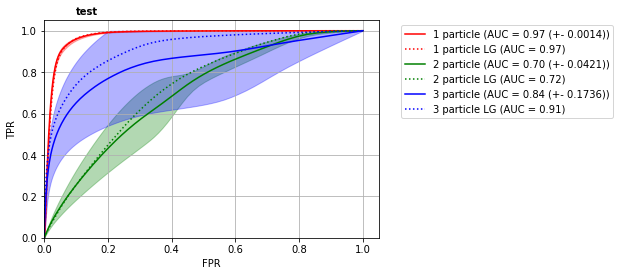

In [24]:
kfoldRoc('output/NumberNetworkKFOLD.h5', labels, name='test', outdir='output/') 
#        fprl = fpr_list, tprl = tpr_list, aucl=auc_list)